 # Lección 1: Computación reversible
 
 Primero, realizamos los imports necesarios.

In [2]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

Definimos la cadena que queremos evaluar

In [161]:
cadena = '1001'

Definimos el registro cuántico donde se va a realizar el procesamiento de la cadena, así como el registro clásico donde se va a almacenar el resultado del cómputo. Es importante recordar que los cómputos reversibles de AND u OR necesitan de **bits de ancila**. Este registro también debe crearse

In [162]:
# Guardamos la longitud de la cadena por facilidad
nbits = len(cadena)
# Registro para procesamiento
cadena_procesada = QuantumRegister(nbits,name='ce')
# Registro de ancila
ancila = QuantumRegister(nbits//2-1,name='anc')
# Registro de salida
es_palind = QuantumRegister(1,name= 'p')
# Registro para la medición
mido_palind = ClassicalRegister(1,name='pm')
# Registro para procesamiento
cadena_medida = ClassicalRegister(nbits,name='cm')

Creamos el circuito para realizar el cómputo

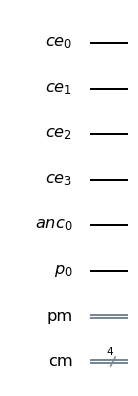

In [163]:
qc_palindromo = QuantumCircuit(cadena_procesada,ancila,es_palind,mido_palind,cadena_medida)
# Dibujamos el circuito
qc_palindromo.draw(output='mpl')

Recordemos que los bits se inicializan en el estado 0, de modo que hay que procesarlos antes de iniciar el computo para almacenar la cadena a evaluar.

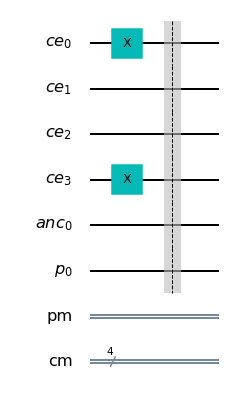

In [164]:
# Aplicamos una compuerta NOT de acuerdo con la info de cadena
for idx in range(nbits):
    if cadena[idx] == '1':
        qc_palindromo.x(cadena_procesada[idx])
# Colocamos una barrera por claridad
qc_palindromo.barrier()
# Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

Procedemos a comparar bits correspondientes usando el algoritmo que hemos discutido. Vamos a determinar si los bits correspondientes son iguales. Esta información va a quedar guardada en los últimos ```nbits//2``` del resgitro de la cadena procesada.

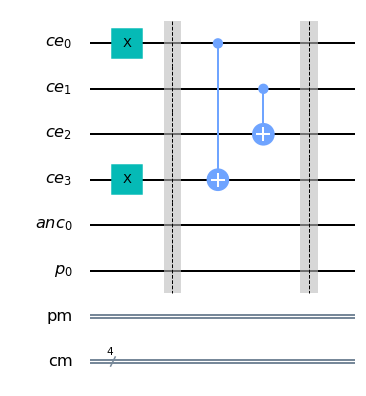

In [165]:
# Aplicamos una compuerta CNOT entre i-ésimo bit y (nbits-1-i)-ésimo bit hasta i = nbits//2
for idx in range(nbits//2):
    qc_palindromo.cx(cadena_procesada[idx],cadena_procesada[nbits-idx-1])
# Colocamos una barrera por claridad
qc_palindromo.barrier()
# Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

Recordemos que si dos bits tienen el mismo valor, la compuerta CNOT cambia al bit objetivo al estado 0. Para evaluar si todos los ```nbits//2``` de la segunda mitad del registro de entrada son cero, vamos a aplicar compuertas Toffoli en cascada para recrear la compuerta NAND, como vimos anteriormente, para ello utilizaremos los bits de ancila.

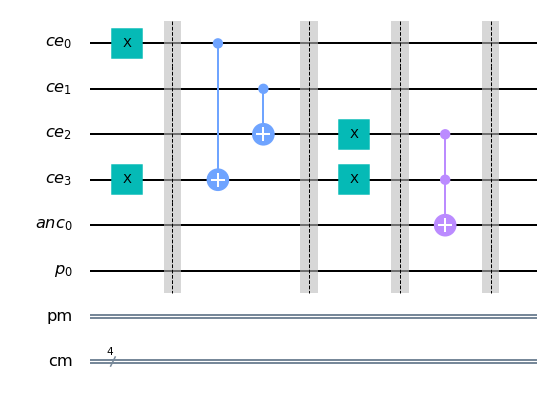

In [166]:
# Determinamos si los últimos nbits//2 bits son todos 0
# Para ello, simulamos NAND utilizando toffoli y NOT
# Primero aplicamos las NOT
offset = nbits//2 + (nbits&1)
for idx in range(offset,nbits):
    qc_palindromo.x(cadena_procesada[idx])
# Colocamos una barrera por claridad
qc_palindromo.barrier()
# Luego las toffoli, utilizando los qbits de ancila
qc_palindromo.ccx(cadena_procesada[offset],cadena_procesada[offset+1],ancila[0])
anc_c = 0
anc_o = 1
for idx in range(offset+2,nbits):
    try:
        qc_palindromo.ccx(cadena_procesada[idx],ancila[anc_c],ancila[anc_o])
        anc_c = anc_c + 1
        anc_o = anc_o + 1
    except:
        continue
# Colocamos una barrera por claridad
qc_palindromo.barrier()
# Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

La clave de la computación reversible es **deshacer el cómputo** por ello necesitamos un registro adicional para copiar el resultado del cómputo que luego vamos a medir. El resultado queda guardado en el último bit del registro de ancila.

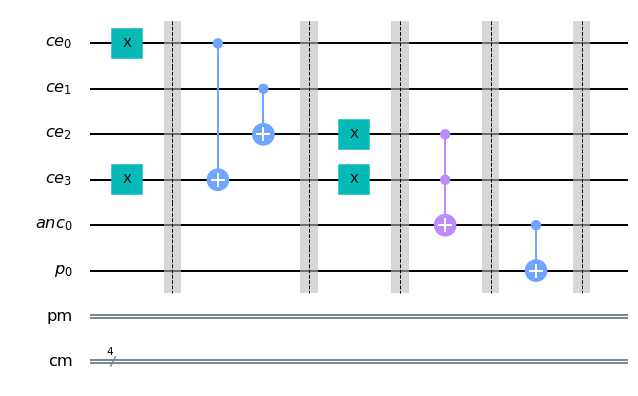

In [167]:
qc_palindromo.cx(ancila[-1],es_palind[0])
# Añadimos una barrera por claridad
qc_palindromo.barrier()
# Dibujamos el circuito
qc_palindromo.draw(output='mpl')

Ahora procedemos a realizar el des-cómputo, revirtiendo todos los pasos hasta la inicialización de la cadena de entrada

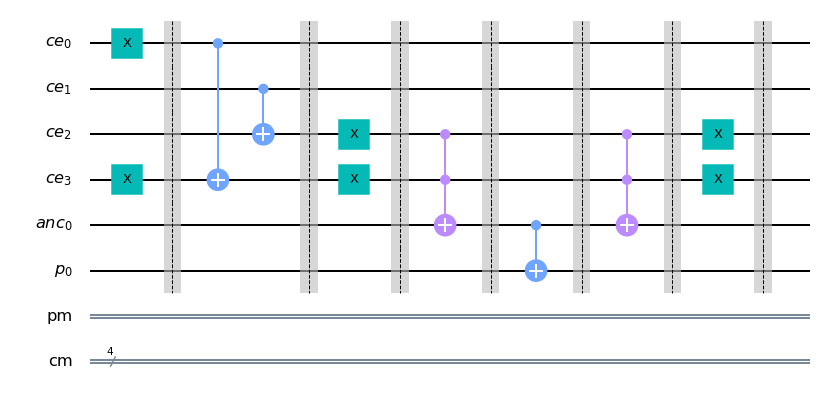

In [168]:
# Desacemos el NAND en cadena
offset = nbits//2 + (nbits&1)
anc_c = nbits//2-3
anc_o = nbits//2-2
for idx in reversed(range(offset+2,nbits)):
    try:
        qc_palindromo.ccx(cadena_procesada[idx],ancila[anc_c],ancila[anc_o])
        anc_c = anc_c - 1
        anc_o = anc_o - 1
    except:
        continue
# Luego las toffoli, utilizando los qbits de ancila
qc_palindromo.ccx(cadena_procesada[offset],cadena_procesada[offset+1],ancila[0])
# Colocamos una barrera por claridad
qc_palindromo.barrier()
# Finalmente, las NOT
for idx in range(offset,nbits):
    qc_palindromo.x(cadena_procesada[idx])
# Colocamos una barrera por claridad
qc_palindromo.barrier()
# Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

Finalmente, deshacemos el cómputo de los bits de comparación

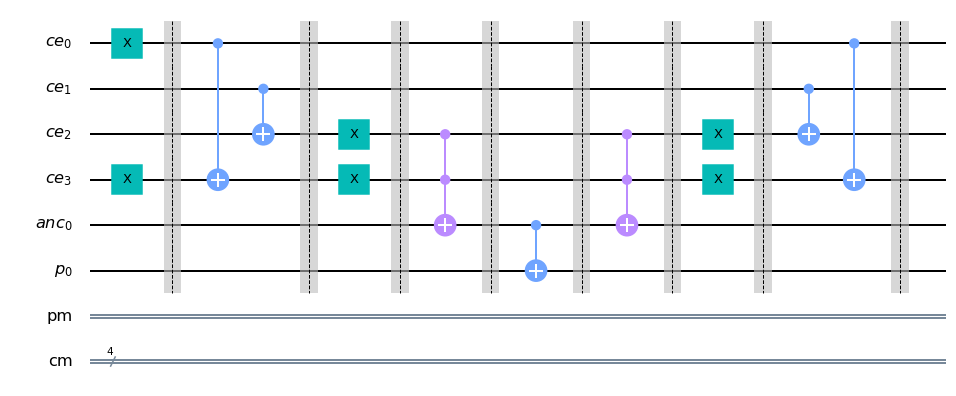

In [169]:
# Aplicamos una compuerta CNOT entre i-ésimo bit y (nbits-1-i)-ésimo bit hasta i = nbits//2
for idx in reversed(range(nbits//2)):
    qc_palindromo.cx(cadena_procesada[idx],cadena_procesada[nbits-idx-1])
# Colocamos una barrera por claridad
qc_palindromo.barrier()
# Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

Resta medir la cadena procesada en el registro de cadena medida, y el indicador de si esta es palíndroma, en el registro de medición apropiado

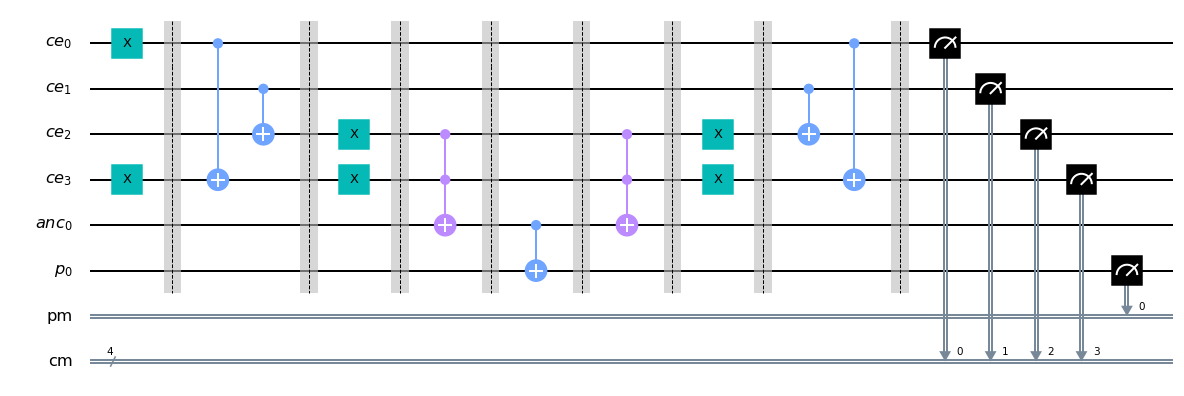

In [170]:
qc_palindromo.measure(cadena_procesada,cadena_medida)
qc_palindromo.measure(es_palind,mido_palind)
# Dibujamos el circuito
qc_palindromo.draw(output='mpl')

Ahora simulamos la cadena utilizando el paquete *Aer* de qiskit

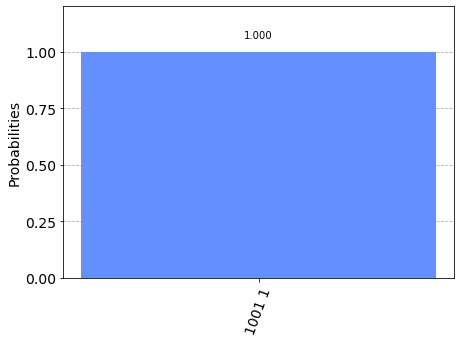

In [171]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc_palindromo,backend).result().get_counts()
plot_histogram(counts)

Tarea para los chicos:

1. Si corren el notebook con una cadena de 3 bits, el algoritmo no funciona. ¿Por qué?
1. Pueden Hacer un circuito que funcione para una cadena de 3 bits.